In [1]:
import json
import mlflow
import optuna
import os
import torch
from optuna.integration.mlflow import MLflowCallback
from src.models.evaluate import check_ndcg_on_val_set
from src.models.train import TrainKNRM
from src.models.knrm_model import KNRM

optuna.logging.set_verbosity(optuna.logging.WARNING)

c:\Users\gwyn\Documents\GitHub\ranking_service\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
PARENT_DIR = os.path.abspath(os.path.join('', os.pardir))
TRAIN_PATH = PARENT_DIR + '/data/raw/QQP/train.tsv'
VAL_PATH = PARENT_DIR + '/data/raw/QQP/dev.tsv'
GLOVE_PATH = PARENT_DIR + '/data/raw/glove.6B.50d.txt'
ML_RUNS_PATH = PARENT_DIR + '/models/ml_runs/'

if 'ml_runs' not in os.listdir(PARENT_DIR + '/models'):
    os.mkdir(ML_RUNS_PATH)

In [3]:
mlflc = MLflowCallback(tracking_uri='file:///' + ML_RUNS_PATH, metric_name='NDCG_at_10')

@mlflc.track_in_mlflow()
def objective(trial, train_path=TRAIN_PATH, val_path=VAL_PATH, glove_path=GLOVE_PATH, ndcg_threshold=0.90):
    params = {
        'train_path': train_path, 'val_path': val_path, 'glove_path': glove_path,
        'random_vec_bound': 1.0, 'seed': 0, 'out_layers': [],
        'num_epochs': 9, 'batch_size': 1024, 'change_every_num_ep': 10,
        'freeze_emb': False, 'min_token_occurancies': 1,
        'num_kernels': trial.suggest_categorical('num_kernels', list(range(10, 25))),
        'sigma': trial.suggest_float('sigma', 1e-4, 1e-1),
        'lr': trial.suggest_float('lr', 1e-2, 6e-2),
        'num_pos_ex': trial.suggest_categorical('num_pos_ex', [2, 3, 4]),
        'num_rand_pos_ex': trial.suggest_categorical('num_rand_pos_ex', [1, 2, 3]),
        'num_same_rel_ex': trial.suggest_categorical('num_same_rel_ex', [2, 3, 4]),
    }
    
    mlflow.log_param("optuna_trial_num", trial.number)
    mlflow.log_params(params)

    model = TrainKNRM(**params)
    model.fit(benchmark_ndcg_score=0.99)
    val_ndcg = check_ndcg_on_val_set(model.knrm, model.val_dataloader)
    
    if val_ndcg > ndcg_threshold:
        MLP_SAVE_PATH = 'mlp'
        EMB_SAVE_PATH = 'embeddings'
        VOCAB_SAVE_PATH = 'vocab'
        mlflow.pytorch.log_state_dict(model.knrm.mlp.state_dict(), MLP_SAVE_PATH)
        mlflow.pytorch.log_state_dict(model.knrm.embeddings.state_dict(), EMB_SAVE_PATH)
        mlflow.log_dict(model.vocab, VOCAB_SAVE_PATH)
    return val_ndcg

C:\Users\gwyn\AppData\Local\Temp\ipykernel_26696\3221957836.py:1: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflc = MLflowCallback(tracking_uri='file:///' + ML_RUNS_PATH, metric_name='NDCG_at_10')
C:\Users\gwyn\AppData\Local\Temp\ipykernel_26696\3221957836.py:3: ExperimentalWarning: track_in_mlflow is experimental (supported from v2.9.0). The interface can change in the future.
  @mlflc.track_in_mlflow()


In [4]:
study = optuna.create_study(study_name='QuoraRankingHyperparameterTuning', direction='maximize')
study.optimize(objective, n_trials=50, callbacks=[mlflc])
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

2023/04/06 15:41:56 INFO mlflow.tracking.fluent: Experiment with name 'QuoraRankingHyperparameterTuning' does not exist. Creating a new experiment.


Number of finished trials: 50
Best trial: {'num_kernels': 11, 'sigma': 0.07963666106711914, 'lr': 0.054005136317890536, 'num_pos_ex': 2, 'num_rand_pos_ex': 2, 'num_same_rel_ex': 2}


In [3]:
if mlflow.get_tracking_uri() != 'file:///' + ML_RUNS_PATH:
    mlflow.set_tracking_uri('file:///' + ML_RUNS_PATH)

In [4]:
experiment_name = "QuoraRankingHyperparameterTuning"
current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id=current_experiment['experiment_id']

In [5]:
experiments_df = mlflow.search_runs(experiment_ids=[experiment_id], filter_string="metrics.NDCG_at_10 > 0.89")
run_id_with_max_ndcg = experiments_df.loc[experiments_df['metrics.NDCG_at_10'].idxmax()]['run_id']
best_params = dict(mlflow.get_run(run_id_with_max_ndcg))['data'].to_dictionary()['params']
best_params['num_epochs'] = 29
del best_params['optuna_trial_num']

for k in best_params:
    try:
        best_params[k] = json.loads(best_params[k])
    except:
        pass

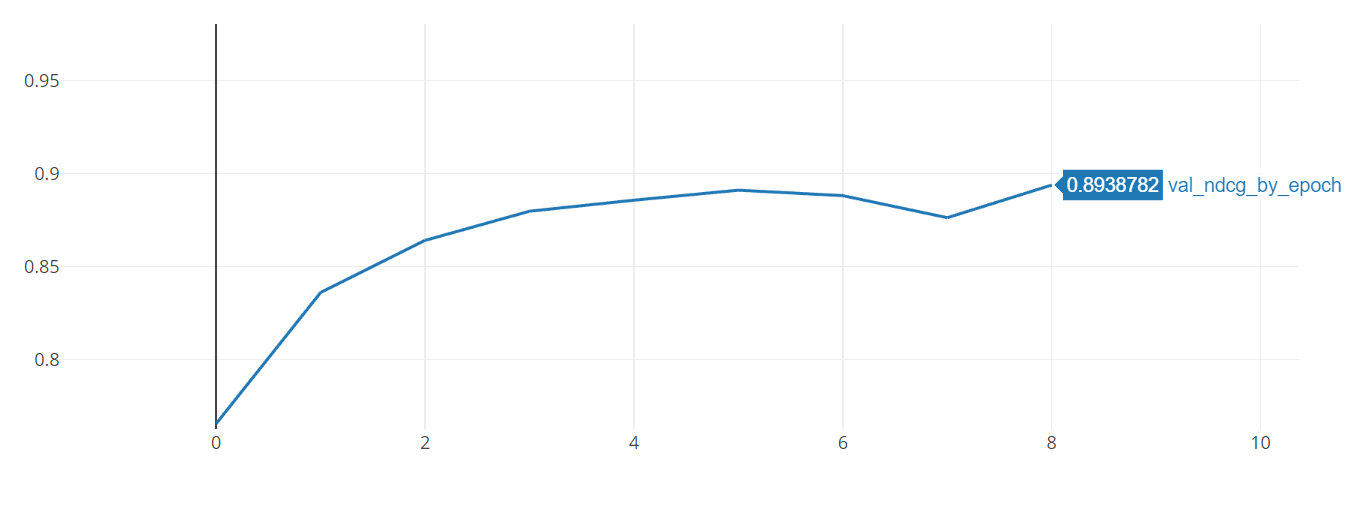

In [6]:
experiment_name = 'QuoraRankingExtendedTraining'
try:
    exp_id = mlflow.create_experiment(name=experiment_name)
except Exception as e:
    exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

In [8]:
with mlflow.start_run(run_name='best_model', experiment_id=exp_id):
    mlflow.log_params(best_params)

    model = TrainKNRM(**best_params)
    model.fit(benchmark_ndcg_score=0.89)
    val_ndcg = check_ndcg_on_val_set(model.knrm, model.val_dataloader)
    
    MODEL_SAVE_PATH = 'model'
    VOCAB_SAVE_PATH = 'vocab'
    mlflow.pytorch.log_model(model.knrm, MODEL_SAVE_PATH)
    mlflow.log_dict(model.vocab, VOCAB_SAVE_PATH)

c:\Users\gwyn\Documents\GitHub\ranking_service\.venv\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


#### Get model

In [17]:
exp_id = mlflow.get_experiment_by_name('QuoraRankingExtendedTraining').experiment_id
run_id = mlflow.search_runs(experiment_ids=[exp_id])['run_id'][0]

In [26]:
model_uri = "runs:/{}/model".format(run_id)
vocab_uri = "runs:/{}/vocab".format(run_id)
loaded_model = mlflow.pytorch.load_model(model_uri)
vocab = mlflow.artifacts.load_dict(vocab_uri)


In [29]:
from src.data.text_retriever import TextRetriever
tr = TextRetriever()

In [52]:
def tokenized_text_to_index(tokenized_text, vocab):
    input_len = len(tokenized_text)
    if input_len > 30:
        text = tokenized_text[:30]
    else:
        text = tokenized_text + (30 - input_len) * [vocab['PAD']]
    token_idxs = []
    for token in text:
        token_idxs.append(vocab.get(token, vocab['OOV']))
    return token_idxs

def get_preds(question1, question2):
    tok_q1 = tr.lower_and_tokenize_words(question1)
    tok_q2 = tr.lower_and_tokenize_words(question2)
    inputs = dict()
    inputs['query'] = torch.LongTensor(tokenized_text_to_index(tok_q1, vocab))[None, :]
    inputs['document'] = torch.LongTensor(tokenized_text_to_index(tok_q2, vocab))[None, :]
    return loaded_model.predict(inputs)

question1 = 'How do I lose weight fast?'
question2 = 'What is the best way to reduce weight fast?'
preds1 = get_preds(question1, question2)

question1 = 'How do I lose weight fast?'
question2 = 'How do you post a question on Quora?'
preds2 = get_preds(question1, question2)

question1 = 'Which is the best cleaning service company in Australia?'
question2 = 'What are the boundaries of the FBI’s geographic jurisdiction?'
preds3 = get_preds(question1, question2)

In [53]:
preds1.item(), preds2.item(), preds3.item()

(18.771255493164062, 18.507234573364258, 16.947589874267578)